# Introduction

# Import Libraries

In [1]:
# import Library
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

# Load Data

In [2]:
# load data
df_ori = pd.read_csv('GOLD.csv')
df_ori.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-12-05,15.470000,15.820000,15.32,15.430000,12.977592,16348300
1,2013-12-06,15.490000,15.680000,15.35,15.400000,12.952355,13779400
2,2013-12-09,15.630000,16.160000,15.61,16.000000,13.456996,17704600
3,2013-12-10,16.549999,17.000000,16.51,16.870001,14.188725,21759600
4,2013-12-11,16.850000,16.879999,16.32,16.379999,13.776601,15990000


In [3]:
df = df_ori.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2516 entries, 0 to 2515
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2516 non-null   object 
 1   Open       2516 non-null   float64
 2   High       2516 non-null   float64
 3   Low        2516 non-null   float64
 4   Close      2516 non-null   float64
 5   Adj Close  2516 non-null   float64
 6   Volume     2516 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 137.7+ KB


In [4]:
df['Date'] = pd.to_datetime(df['Date'], utc=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2516 entries, 0 to 2515
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   Date       2516 non-null   datetime64[ns, UTC]
 1   Open       2516 non-null   float64            
 2   High       2516 non-null   float64            
 3   Low        2516 non-null   float64            
 4   Close      2516 non-null   float64            
 5   Adj Close  2516 non-null   float64            
 6   Volume     2516 non-null   int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1)
memory usage: 137.7 KB


In [5]:
df['Date'] = df['Date'].dt.tz_convert(None)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2516 entries, 0 to 2515
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2516 non-null   datetime64[ns]
 1   Open       2516 non-null   float64       
 2   High       2516 non-null   float64       
 3   Low        2516 non-null   float64       
 4   Close      2516 non-null   float64       
 5   Adj Close  2516 non-null   float64       
 6   Volume     2516 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 137.7 KB


In [6]:
df['Year'] = pd.DatetimeIndex(df['Date']).year
df['Month'] = pd.DatetimeIndex(df['Date']).month
df['Day']=df[ "Date"].dt.day
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Year,Month,Day
2511,2023-11-28,16.670000,17.469999,16.600000,17.440001,17.340000,32256300,2023,11,28
2512,2023-11-29,17.309999,17.500000,17.230000,17.389999,17.389999,17301000,2023,11,29
2513,2023-11-30,17.299999,17.610001,17.250000,17.590000,17.590000,19571700,2023,11,30
2514,2023-12-01,17.559999,17.790001,17.510000,17.730000,17.730000,22998200,2023,12,1
2515,2023-12-04,17.600000,17.650000,17.360001,17.530001,17.530001,20853700,2023,12,4


In [7]:
df.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume','Year','Month','Day'], inplace=True)
df.head()

,Date,Close
0,2013-12-05,15.430000
1,2013-12-06,15.400000
2,2013-12-09,16.000000
3,2013-12-10,16.870001
4,2013-12-11,16.379999


In [8]:
close = df.copy()
close.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2516 entries, 0 to 2515
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2516 non-null   datetime64[ns]
 1   Close   2516 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 39.4 KB


Text(0, 0.5, 'Num of Close price')

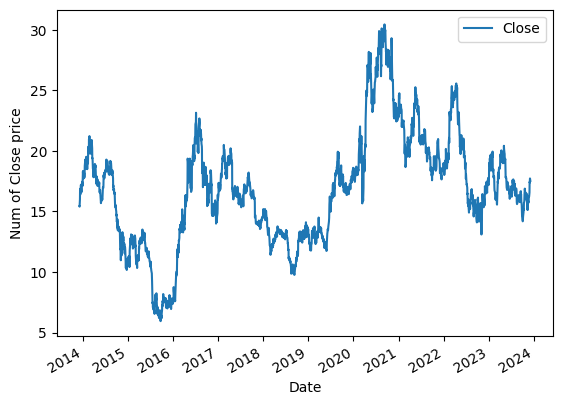

In [9]:
# Plot the data
close.columns = ['Date', 'Close']   
close.Date = pd.to_datetime(close.Date)
close.set_index('Date',inplace=True)
close.plot()
plt.xlabel('Date')
plt.ylabel('Num of Close price')

In [10]:
close.tail()

,Close
Date,
2023-11-28,17.440001
2023-11-29,17.389999
2023-11-30,17.590000
2023-12-01,17.730000
2023-12-04,17.530001


# Modeling

## ARIMA

In [11]:
# Create a function to find best model
def find_best_model(data, num_p, num_d, num_q):
  df = pd.DataFrame() #We make a pandas dataframe to ease our work, you can use any way that makes you comfortable and work easly
  pdq = [[],[],[]] #This list for storing the combinations of p and q
  aic = [] # This list for storing aic value
  for p in range(num_p + 1): #plus one is to make the range up to num_p since python range only ranging from 0 to N-1
    for d in range(num_d + 1):
      for q in range(num_q + 1):
        # #if p!=0 and q!=0: #this logic will avoid (0,0) value which is not correct
        try: #Using exception to avoid the error while training the model with certain p and q value
          model = ARIMA(data, order=(p, d, q))
          result = model.fit()
          pdq[0].append(p)
          pdq[1].append(d)
          pdq[2].append(q)
          aic.append(result.aic)
        except:
          pass #If there is an error caused by the calculation, it will be skipped to the next iteration

  df['p'] = pdq[0]
  df['d'] = pdq[1]
  df['q'] = pdq[2]
  df['AIC'] = aic

  df.sort_values('AIC', inplace=True)

  return df.p.iloc[0], df.d.iloc[0], df.q.iloc[0], df.AIC.iloc[0], df

In [12]:
# Find best model of ARIMA with combinations of p=4, d=4, q=4
find_best_model(close['Close'], 4, 4, 4)

(3,
 1,
 2,
 2755.716615902433,
      p  d  q           AIC
 82   3  1  2   2755.716616
 59   2  1  4   2757.831669
 83   3  1  3   2757.942682
 84   3  1  4   2759.668639
 109  4  1  4   2761.780447
 ..  .. .. ..           ...
 2    0  0  2   9375.273539
 20   0  4  0  10248.329376
 4    0  0  4  11142.322858
 1    0  0  1  11694.990479
 0    0  0  0  14891.807568
 
 [125 rows x 4 columns])

In [13]:
# Train ARIMA with best combinations
model_arima_414 = ARIMA(close['Close'], order=(4, 1, 4))
result_model_arima_414 = model_arima_414.fit()

print('The AIC is ', result_model_arima_414.aic)

The AIC is  2761.780446723521


In [14]:
# Predict next 12 months
len_dataset = close.shape[0]
len_predict = len_dataset + 12

new_pred = result_model_arima_414.predict(len_dataset, len_predict)
new_pred = pd.DataFrame(new_pred)
new_pred.columns=['Close']
all_dataset_with_pred = pd.concat([close, new_pred], axis=0)

In [15]:
# Original dataset
close.tail(5)

,Close
Date,
2023-11-28,17.440001
2023-11-29,17.389999
2023-11-30,17.590000
2023-12-01,17.730000
2023-12-04,17.530001


In [16]:
# Prediction of next 12 months
new_pred

,Close
2516,17.493481
2517,17.537768
2518,17.524589
2519,17.487906
2520,17.532109
2521,17.520474
2522,17.491081
2523,17.535853
2524,17.521679
2525,17.493739


### Model Training

In [17]:
# Splitting dataset
train = close[:1200]
test = close[1200:]

print('Train size : ', train.shape)
print('Test size : ', test.shape)

Train size :  (1200, 1)
Test size :  (1316, 1)


In [18]:
# Create a function to check stationarity

def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [19]:
# Stationarity check
check_stationarity(train['Close'])

ADF Statistic: -1.493289
p-value: 0.536829
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Non-stationary


In [20]:
# First-order differencing

check_stationarity(train['Close'].diff().dropna())

ADF Statistic: -36.002183
p-value: 0.000000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Stationary


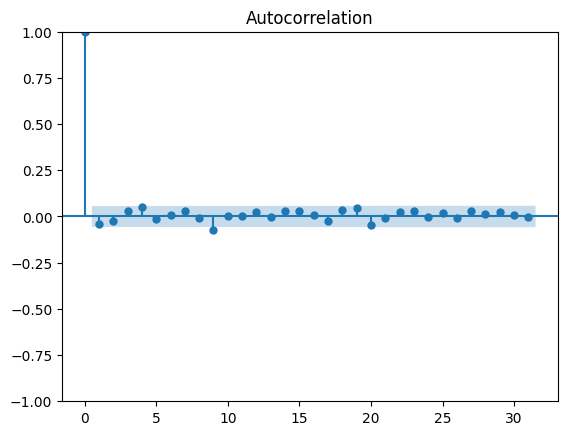

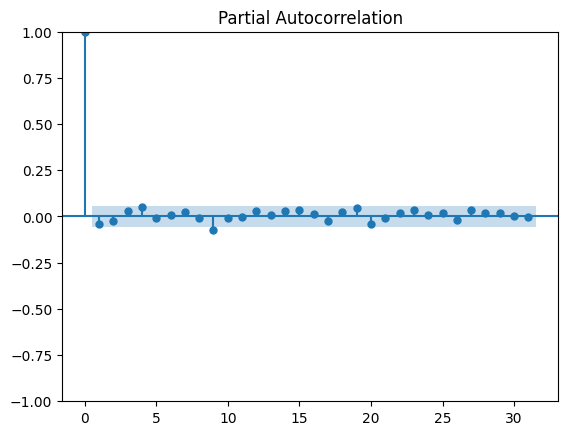

In [21]:
# Plot ACF & PACF from the original dataset
plot_acf(train['Close'].diff().dropna())
plot_pacf(train['Close'].diff().dropna())
plt.show()

In [22]:
# Train with p=2, d=2, q=1
arima = ARIMA(train, order=(2, 2, 1))
mod_train = arima.fit()
mod_train.aic

1091.6632329927384

## SARIMA

In [23]:
# Splitting dataset

train = close[:1200]
test = close[1200:]

print('Train size : ', train.shape)
print('Test size : ', test.shape)

Train size :  (1200, 1)
Test size :  (1316, 1)


In [24]:
train

,Close
Date,
2013-12-05,15.430000
2013-12-06,15.400000
2013-12-09,16.000000
2013-12-10,16.870001
2013-12-11,16.379999
...,...
2018-09-05,9.850000
2018-09-06,9.920000
2018-09-07,10.050000


In [25]:
test

,Close
Date,
2018-09-12,10.080000
2018-09-13,10.110000
2018-09-14,10.110000
2018-09-17,10.350000
2018-09-18,10.480000
...,...
2023-11-28,17.440001
2023-11-29,17.389999
2023-11-30,17.590000


### Model Training

In [26]:
# Train using SARIMAX
sar=SARIMAX(train['Close'], order=(2, 2, 2),seasonal_order=(2, 2, 2, 12)).fit()
sar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Close   No. Observations:                 1200
Model:             SARIMAX(2, 2, 2)x(2, 2, 2, 12)   Log Likelihood                -634.957
Date:                            Wed, 06 Dec 2023   AIC                           1287.913
Time:                                    17:37:12   BIC                           1333.527
Sample:                                         0   HQIC                          1305.114
                                           - 1200                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0341      0.277     -3.737      0.000      -1.576      -0.492
ar.L2         -0.0353      0.029     -1.228      0.220      -0.092       0.021
ma.L1         -0.0011      0.260     -0.004      0.997      -0.511       0.509
ma.L2         -0.9989      0.709     -1.408      0.159      -2.389       0.392
ar.S.L12       0.0462      0.031      1.471      0.141      -0.015       0.108
ar.S.L24       0.0174      0.026      0.670      0.503      -0.033       0.068
ma.S.L12      -1.9857      0.050    -39.890      0.000      -2.083      -1.888
ma.S.L24       0.9872      0.049     20.078      0.000       0.891       1.084
sigma2         0.1490      0.071      2.094      0.036       0.010       0.288
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               707.45
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               0.69   Skew:                            -0.45
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [27]:
train['Close']

Date
2013-12-05    15.430000
2013-12-06    15.400000
2013-12-09    16.000000
2013-12-10    16.870001
2013-12-11    16.379999
                ...    
2018-09-05     9.850000
2018-09-06     9.920000
2018-09-07    10.050000
2018-09-10     9.760000
2018-09-11     9.770000
Name: Close, Length: 1200, dtype: float64

In [33]:
close

,Close
Date,
2013-12-05,15.430000
2013-12-06,15.400000
2013-12-09,16.000000
2013-12-10,16.870001
2013-12-11,16.379999
...,...
2023-11-28,17.440001
2023-11-29,17.389999
2023-11-30,17.590000


In [31]:
close['Date'] = pd.to_datetime(close['Date'])
close.set_index('Date', inplace=True)


KeyError: 'Date'

In [30]:
start_date = '2023-12-05'
end_date = '2023-12-05'
predictions = sar.get_prediction(start=start_date, end=end_date, dynamic=True)

# Ekstrak hasil prediksi
predicted_values = predictions.predicted_mean

# Tampilkan hasil prediksi
print(predicted_values)

KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'